## Problem 1
Download the Yelp User dataset from Canvas. In this dataset, each row represents a unique user, while each column describes a specific feature. The first line of the csv file contains identifiers explaining each column.
Using this data, formulate a clustering problem. You should use as many of the available features as possible (but need not use them all). You may change the data representation or create new features from this data, if you wish.

In [1]:
import pandas as pd
import random
import numpy as np
import time
data = pd.read_csv('yelp.csv')

In [2]:
# data # 1326100 * 21

In [3]:
# data perprocessing
data['yelping_year'] = pd.to_numeric(data['yelping_since'].str.split('-').str[0])
data['yelping_year'] = data['yelping_year'].map(lambda x: 2018 - x)
data['ufcf_sum'] = data['useful']+data['funny']+data['cool']+data['fans']
data['compliment_sum'] = data['compliment_more']+data['compliment_profile']+data['compliment_cute']+data['compliment_list']+data['compliment_note']+data['compliment_plain']+data['compliment_cool']+data['compliment_funny']+data['compliment_writer']+data['compliment_photos']
data['elite_count'] = data['elite'].str.split(',')
data['elite_count'] = data['elite_count'].map(lambda x:len(x) if x != ['None'] else 0)

In [4]:
data1 = data[['review_count','yelping_year','ufcf_sum','compliment_sum','elite_count']]

In [5]:
data1.head()

,review_count,yelping_year,ufcf_sum,compliment_sum,elite_count
0,10,5,0,0,0
1,1,1,0,0,0
2,6,3,0,0,0
3,3,2,0,0,0
4,11,6,4,1,0


In [6]:
dataset = np.array(data1).astype(np.float64)

## Problem 2
Based on your problem formulation from Problem 1, implement an online version of the k-means clustering algorithm. For this problem, your initial cluster centroids should be chosen randomly. Once the cluster centroids are chosen, the next step is to iteratively improve the solution until a local optimum is achieved. As discussed in the lectures, Lloyd’s heuristic is one approach, but this requires taking a pass over the entire dataset each time, which is not feasible here. Instead, implement mini-batch k-means, which will adjust the centroids by taking a subset of the data each time.

In [13]:
def minibatchKmeans(k, b, data, T):
    # initialization
    centers = data[list(random.sample(range(0,len(data)),k))]
    # record #updates for each centroid
    v = np.zeros([k,1], dtype = float)
    for i in range(T):
        # Selecting the sample data
        sample_data = data[list(random.sample(range(0,len(data)),b))]
        # For each sample data, updating its nearest center
        for j in range(b):
            distance = np.linalg.norm((sample_data[j]-centers),axis = 1)
            # Finding the center index
            min_index = np.argmin(distance)
            v[min_index] += 1
            ita = 1/v[min_index]
            centers[min_index]  = (1-ita)*centers[min_index] + ita*sample_data[j] 
    return centers

In [12]:
start = time.clock()

centers = minibatchKmeans(500, 1000, dataset, 1000) #k=50: 0.34min; k=500: 0.41min

elapsed = (time.clock()-start)/60
print("minute used: ",elapsed)

minute used:  0.4176529


## Problem 3.
In this setting, the optimization problem being solved is highly non-convex, and many local minima exist; hence, the choice of the initial centroids can dramatically influence results. For this problem, implement the k-means++ initialization as discussed in class for the online mini-batch algorithm.

In [16]:
def disSqToCloseC(X,C):
    '''
    input: X, m*n; C, k*n
    '''
    dis = -2*np.dot(X,C.T) # m*k, all the distances between datas X and centers C
    dis += np.sum(X**2,axis=1)[:,np.newaxis] # axis = 1, row
    dis += np.sum(C**2,axis=1)[np.newaxis,:] # axis = 0, col
    min_ds_sq = np.min(dis, axis = 1) # m*1 (minimum distance to centers)
    return min_ds_sq

In [17]:
def kmeanspp(data,k):
    center_pos = []
    total = 0
    first = random.choice(range(len(data)))
    center_pos.append(first)
    for i in range(1,k):
        weights = disSqToCloseC(data,data[center_pos])
        weights1 = weights/sum(weights)
        rand = random.random()
        cdf = 0
        idx = -1
        while cdf < rand:
            idx += 1
            cdf += weights1[idx]
        center_pos.append(idx)
    return data[center_pos]

In [18]:
def minibatchKmeanspp(k, b, data, T):
    # initialization
    centers = kmeanspp(data,k)
    # #updates for each centroid
    v = np.zeros([k,1], dtype = float)
    for i in range(T):
        # Selecting the sample data
        sample_data = data[list(random.sample(range(0,len(data)),b))]
        # For each sample data, finding the nearest center
        for j in range(b):
            distance = np.linalg.norm((sample_data[j]-centers),axis = 1)
            # Finding the center index
            min_index = np.argmin(distance)
            v[min_index] += 1
            ita = 1/v[min_index]
            centers[min_index]  = (1-ita)*centers[min_index] + ita*sample_data[j] 
    return centers

In [22]:
start = time.clock()

center_pos = minibatchKmeanspp(300,1000,dataset,1000) # k=50:1min;k=300:12.65min

elapsed = (time.clock()-start)/60
print("minute used: ",elapsed)

minute used:  12.652489766666667


## Problem 4
Design your own method of selecting initial cluster centroids. Remember that the dataset is quite large, so your initialization should be efficient. Your centroid selection algorithm should take no more than 5 minutes to run.

In [108]:
def getinitC(k,data,b,T):
    ## First, finding the column which has highest standard deviation 
    dev_list = data.std(axis=0)
    dev_list = dev_list.tolist() ## Converting to list to find the index
    col_idx = dev_list.index(max(dev_list))
    ## Then, we changed the order of the matrix accoring to the column order
    order= np.argsort(data[:,col_idx]) # Finding the order that the elements of column in order (min -> max)  
    data_neworder = data[order] ## Getting the dataset which is in new order
    ## After that, we need to split the data into k parts.
    dataset_list = []
    for i in range(k):
        dataset_list.append(data_neworder[i*(len(data_neworder)//k):(i+1)*(len(data_neworder)//k)])
    if (len(data_neworder)%k) == 0:
        pass
    else:
        ## If the number of points is not integer multiple of k, remaining points will be added to the last one cluster
        dataset_list[-1] = np.r_[dataset_list[-1], data_neworder[-(len(data_neworder)-k*(len(data_neworder)//k)):]]
    ## Now, we have a dataset_list, which have k items(matrixs),
    ## We need to find only one center in each matrix
    center_list = []
    for matrix in dataset_list:
        center_list.append(minibatchKmeans(1,b,matrix,T)) ## The list should have k items, each is 1*5.
    ## If wanna return a matrix
    centers_final = np.zeros([k,5])
    for center in center_list:
        centers_final = np.r_[centers_final,center]
    centers_final = centers_final[k:,]
    return centers_final

In [111]:
def minibatchKmeansOwn(k, b, data, T):
    # initialization
    centers = np.array(getinitC(k,data,100,100))
    # the counts of updating each centroid
    v = np.zeros([k,1], dtype = float)
    for i in range(T):
        X = data[list(random.sample(range(0,len(data)),b))]
        dis = -2*np.dot(X,centers.T) # b*k
        dis += np.sum(X**2,axis=1)[:,np.newaxis] # axis = 1, row
        dis += np.sum(centers**2,axis=1)[np.newaxis,:]
        min_index = np.argmin(dis, axis=1) # b*1
        for j in range(b):
            idx = min_index[j]
            v[idx] += 1
            ita = 1/v[idx]
            centers[idx] = (1-ita)*centers[idx] + ita*X[j] 
    return centers

## Problem 5
For each initialization method, generate plots showing the mean, minimum, and maximum distance to the cluster centroids for the dataset, and run this for several values of the number of centroids k, ranging from k = 5, . . . , 500. Which k has the lowest error, and how does that change based on the initialization? Which initialization is best?

In [101]:
def evaluate(data, centers):
    dis = -2*np.dot(data,centers.T) # m*k, all the distances between datas X and centers C
    dis += np.sum(data**2,axis=1)[:,np.newaxis] # axis = 1, row
    dis += np.sum(centers**2,axis=1)[np.newaxis,:] # axis = 0, col
    dis = np.sqrt(np.abs(dis))    
    min_d = np.min(dis,axis = 1)
    mean = np.mean(min_d)
    minn = np.min(min_d)
    maxx = np.max(min_d)
    return mean, minn, maxx

In [82]:
# random
start = time.clock()

ks = [5,10,50,100,150,200,250,300,350,400,450,500] # time: 17min
# k varies, b=1000, data, T=200
centers = []
means = []
minns = []
maxxs = []
for k in ks:
    print("k",k)
    center = minibatchKmeans(k, 1000, dataset, 200) 
    meann, minn, maxx = evaluate(dataset,center)
    centers.append(center)
    means.append(meann)
    minns.append(minn)
    maxxs.append(maxx)
    
elapsed = (time.clock()-start)/60
print("minute used: ",elapsed)

k 5
k 10
k 50
k 100
k 150
k 200
k 250
k 300
k 350
k 400
k 450
k 500
minute used:  5.558661699999963


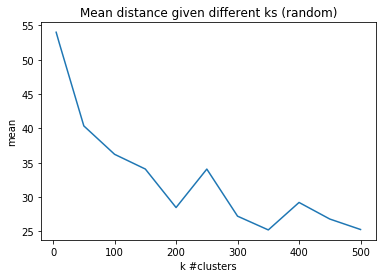

In [83]:
from matplotlib import pyplot as plt
# plot mean min & max       
plt.plot(ks,means)
plt.xlabel('k #clusters')
plt.ylabel('mean')
plt.title("Mean distance given different ks (random)")
plt.show()

In [84]:
# mean min max of random method
print("meanspp",means)
print("minnspp",minns)
print("maxxspp",maxxs)

meanspp [53.99022454535128, 52.42370319530689, 40.35938393978693, 36.228390159984414, 34.08412557472313, 28.481991420518014, 34.0760859953918, 27.225440522198753, 25.22557177231526, 29.221671454068055, 26.808265574755143, 25.285604197974806]
minnspp [0.43435908459693356, 0.3276618865364444, 0.022691269078636805, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
maxxspp [666405.5850189615, 666644.7085146975, 656671.0289872445, 640606.1448198278, 639642.4571144939, 603579.9510787335, 658154.319256516, 593587.6129568394, 553629.3229722008, 643191.8221670089, 589589.0291315503, 516887.5446114259]


In [112]:
# own method
start = time.clock()

ks = [5,10,50,100,150,200,250,300,350,400,450,500] # time: 17min
# k varies, b=1000, data, T=200
centersown = []
meansown = []
minnsown = []
maxxsown = []
for k in ks:
    print("k",k)
    center = minibatchKmeansOwn(k, 1000, dataset, 200)
    meann, minn, maxx = evaluate(dataset,center)
    centersown.append(center)
    meansown.append(meann)
    minnsown.append(minn)
    maxxsown.append(maxx)
    
elapsed = (time.clock()-start)/60
print("minute used: ",elapsed)

k 5
k 10
k 50
k 100
k 150
k 200
k 250
k 300
k 350
k 400
k 450
k 500
minute used:  14.793544199999936


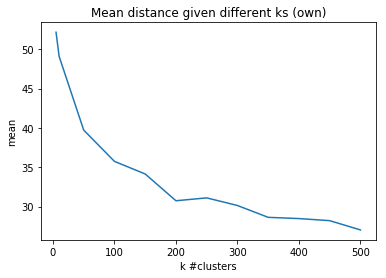

In [113]:
from matplotlib import pyplot as plt
# plot mean min & max       
plt.plot(ks,meansown)
plt.xlabel('k #clusters')
plt.ylabel('mean')
plt.title("Mean distance given different ks (own)")
plt.show()

In [114]:
# mean min max of own method
print("meansown",meansown)
print("minnsown",minnsown)
print("maxxsown",maxxsown)

meansown [52.162532229770406, 49.094326979289185, 39.71986468766933, 35.74792616235197, 34.14484180169499, 30.741722133910724, 31.107312262988245, 30.14014908375965, 28.63336032702109, 28.477000236802457, 28.212532566316714, 27.03475129855162]
minnsown [0.3305630847189503, 0.5223509617100421, 1.1920928955078125e-07, 0.19952352590828554, 0.14562118126270954, 0.0, 0.1837191934279376, 0.0, 1.1920928955078125e-07, 0.0, 0.0, 0.0]
maxxsown [647426.7012010026, 653856.5593648385, 637828.3993235184, 627803.9302922419, 626884.6638306847, 519799.9513442313, 608622.4849194715, 553804.5681877761, 604451.4001840391, 578938.6943853357, 614211.0488500809, 590151.5367824464]


In [90]:
# kmeans++
start = time.clock()

ks = [5,10,50,100,150,200,250,300,350,400,450,500]
# k varies, b = 1000, data, T = 80
centerspp = []
meanspp = []
minnspp = []
maxxspp = []
for k in ks:
    print("k",k)
    center = minibatchKmeanspp(k, 1000, dataset, 100) 
    meann, minn, maxx = evaluate(dataset,center)
    centerspp.append(center)
    meanspp.append(meann)
    minnspp.append(minn)
    maxxspp.append(maxx)
    
elapsed = (time.clock()-start)/60
print("minute used: ",elapsed)

k 5
k 10
k 50
k 100
k 150
k 200
k 250
k 300
k 350
k 400
k 450
k 500
minute used:  137.62771431666673


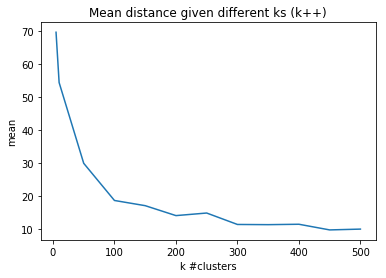

In [91]:
from matplotlib import pyplot as plt
# plot mean min & max       
plt.plot(ks,meanspp)
plt.xlabel('k #clusters')
plt.ylabel('mean')
plt.title("Mean distance given different ks (k++)")
plt.show()

In [92]:
# mean min max of kmeans++ method
print("meanspp",meanspp)
print("minnspp",minnspp)
print("maxxspp",maxxspp)

meanspp [69.76085770489725, 54.486812630305735, 29.97007279654489, 18.683918369660287, 17.10802206252377, 14.09148636744423, 14.872889674042971, 11.401857222979526, 11.342638350318014, 11.465080391869629, 9.745774674100659, 9.992031402104137]
minnspp [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
maxxspp [373779.5352383541, 210606.04878777819, 50537.76079329198, 21687.302921294755, 17806.947604797402, 11408.724117972175, 12409.55659965335, 8563.360482310669, 7648.389111440395, 7938.987529905813, 9771.678207964074, 6564.3055230542095]


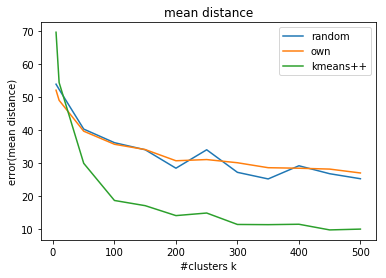

In [118]:
plt.plot(ks,means)
plt.plot(ks,meansown)
plt.plot(ks,meanspp)
plt.legend(labels = ['random','own','kmeans++'], loc = 'best')
plt.xlabel('#clusters k')
plt.ylabel('error(mean distance)')
plt.title("mean distance")
plt.show()

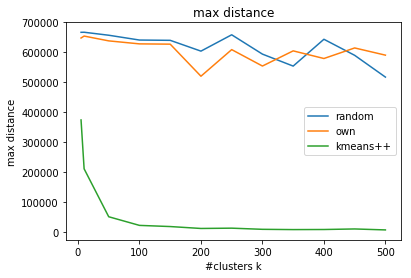

In [124]:
plt.plot(ks,maxxs)
plt.plot(ks,maxxsown)
plt.plot(ks,maxxspp)
plt.legend(labels = ['random','own','kmeans++'], loc = 'best')
plt.xlabel('#clusters k')
plt.ylabel('max distance')
plt.title("max distance")
plt.show()

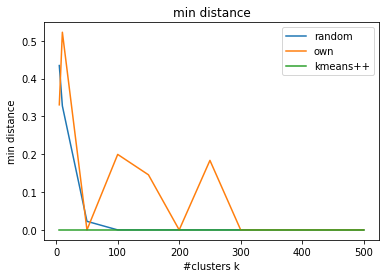

In [125]:
plt.plot(ks,minns)
plt.plot(ks,minnsown)
plt.plot(ks,minnspp)
plt.legend(labels = ['random','own','kmeans++'], loc = 'best')
plt.xlabel('#clusters k')
plt.ylabel('min distance')
plt.title("min distance")
plt.show()